## Adidas Data Challenge 

Author: [**Raffi Sahakyan**](https://www.linkedin.com/in/raffi-sahakyan) in collaboration with group members from UCLA Anderson MSBA Class of 2020
MS in Business Aanlytics Candidate at UCLA Anderson

Data Challenge provided by Holger Komm, Head of Advanced Analytics at Adidas, during his visit to UCLA MSBA Anderson.  

The objective of the challenge was to solve the current mismatch in clothing sizes across the world, where size "M" is varying from Asia to North America — having provided body measurements of the US Army. A unified size scale needed to be created, one that would fit everyone. This scale would give the opportunity to eliminate the current confusion and ease the production process. 

<hr style="height:2px; border:none; color:#000; background-color:#000;">

In [107]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import recall_score, roc_auc_score, mean_squared_error, confusion_matrix, classification_report, f1_score, silhouette_score
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.manifold import TSNE

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [108]:
data_raw = pd.read_csv("https://raw.githubusercontent.com/raffisahakyan/Raw_Data/master/ANSUR%20II%20MALE%20Public.csv", encoding = "ISO-8859-1", header=0)
data_raw.head(2)

,subjectid,abdominalextensiondepthsitting,acromialheight,acromionradialelength,anklecircumference,axillaheight,balloffootcircumference,balloffootlength,biacromialbreadth,bicepscircumferenceflexed,...,Branch,PrimaryMOS,SubjectsBirthLocation,SubjectNumericRace,Ethnicity,DODRace,Age,Heightin,Weightlbs,WritingPreference
0,10027,266,1467,337,222,1347,253,202,401,369,...,Combat Arms,19D,North Dakota,1,NaN,1,41,71,180,Right hand
1,10032,233,1395,326,220,1293,245,193,394,338,...,Combat Support,68W,New York,1,NaN,1,35,68,160,Left hand


Since the analysis is conducted for T-shirt, upper body parts are selected out of the 108 body features. For example, "balloffootlength" and "SubjectsBirthLocation" are eliminated.

In [109]:
df = data_raw[["cervicaleheight", "chestbreadth", "chestcircumference", "chestdepth", "chestheight", "elbowrestheight",
         "forearmcenterofgriplength", "forearmcircumferenceflexed", "forearmforearmbreadth", "forearmhandlength",
         "abdominalextensiondepthsitting", "acromionradialelength", "biacromialbreadth", "bicepscircumferenceflexed", 
         "bicristalbreadth", "bideltoidbreadth", "waistbreadth", "waistcircumference", "waistdepth", "waistfrontlengthsitting",
         "wristcircumference", "wristheight", "Heightin", "neckcircumferencebase", "shoulderlength", "waistbacklength", 
         "hipbreadth", "hipbreadthsitting", "interscyei", "interscyeii"]]

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4082 entries, 0 to 4081
Data columns (total 30 columns):
cervicaleheight                   4082 non-null int64
chestbreadth                      4082 non-null int64
chestcircumference                4082 non-null int64
chestdepth                        4082 non-null int64
chestheight                       4082 non-null int64
elbowrestheight                   4082 non-null int64
forearmcenterofgriplength         4082 non-null int64
forearmcircumferenceflexed        4082 non-null int64
forearmforearmbreadth             4082 non-null int64
forearmhandlength                 4082 non-null int64
abdominalextensiondepthsitting    4082 non-null int64
acromionradialelength             4082 non-null int64
biacromialbreadth                 4082 non-null int64
bicepscircumferenceflexed         4082 non-null int64
bicristalbreadth                  4082 non-null int64
bideltoidbreadth                  4082 non-null int64
waistbreadth                 

Since the body parts are usually highly correlated, we will plot the heatmap to remove the multicollinearity.

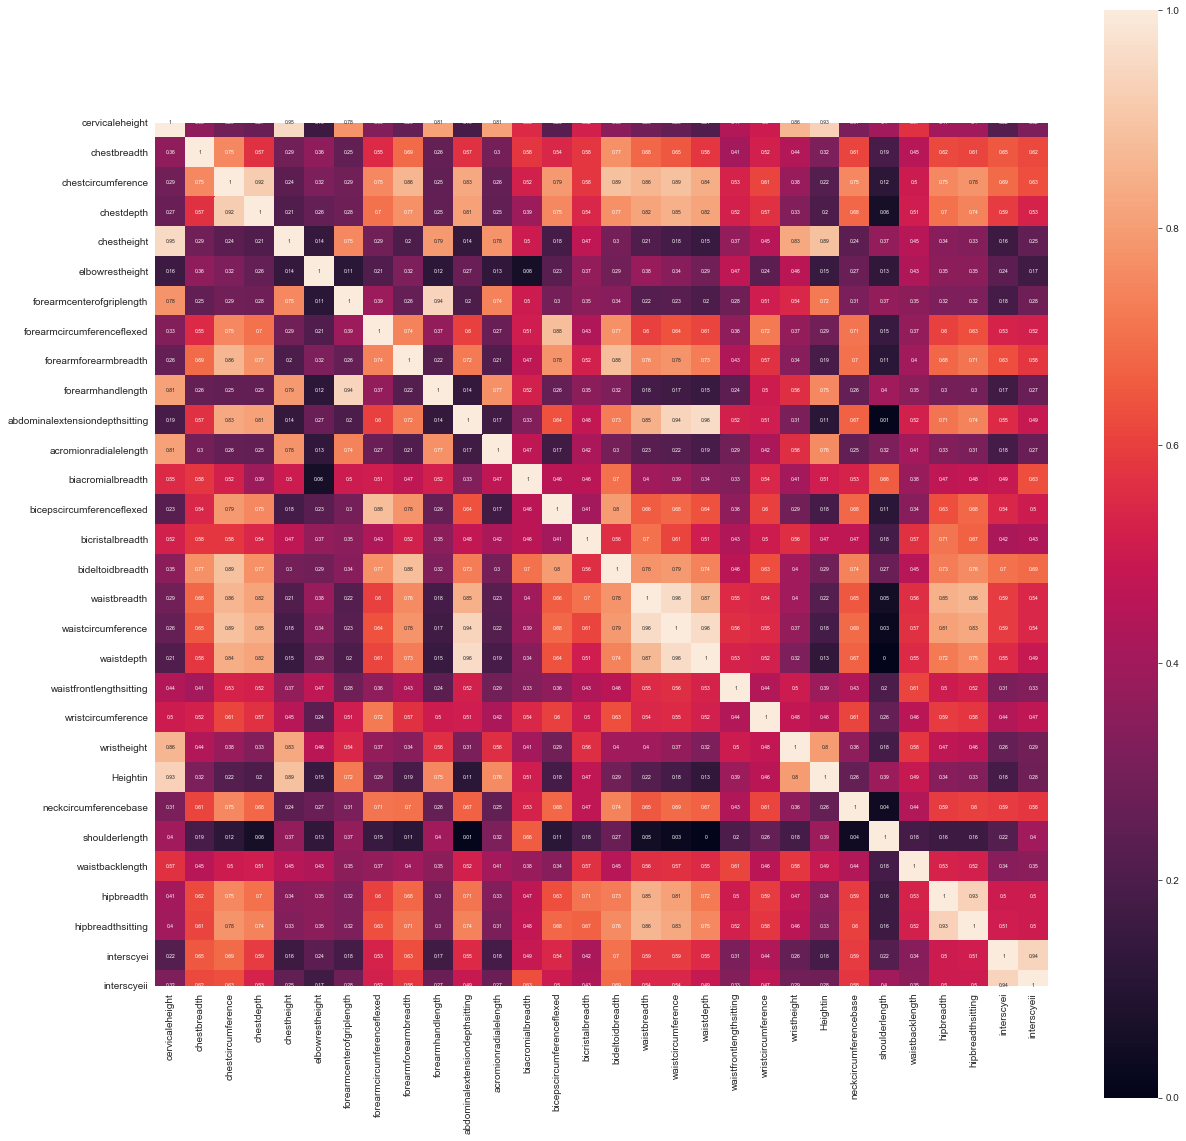

In [110]:
plt.figure(figsize=(20,20))
ax = sn.heatmap(df.corr().abs().round(2), 
                 annot=True, annot_kws = { "size" : 5 }, square=True, cbar=True)


In [111]:
#Removing correlated features
correlated_features = set()
correlation_matrix = df.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) >= 0.85:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

df_new=df.drop(labels=correlated_features, axis=1)

In [112]:
#Applying Minmax scaler for Kmeans clustering
mms = MinMaxScaler()
mms.fit(df_new) 
df_scaled = pd.DataFrame(mms.transform(df_new),columns = df_new.columns)

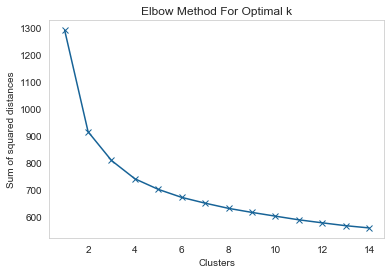

In [113]:
#Elbow method of optimal cluster size selection
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_scaled)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-', color = '#176397')
plt.xlabel('Clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.savefig("Elbow_chart")
plt.show()

The optimal cluster number ideally is 4, however having four sizes is not applicable in reality, so we will go for 6 sizes.

In [115]:
#Kmeans clustering
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans.fit(df_scaled)

#adding the clusters to the dataset for understanding the feature importances
df_scaled["cluster"] = kmeans.labels_

In [116]:
#We will use t-SNE for plotting the clusters in 2d dimension.
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df_new)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4082 samples in 0.007s...
[t-SNE] Computed neighbors for 4082 samples in 0.413s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4082
[t-SNE] Computed conditional probabilities for sample 2000 / 4082
[t-SNE] Computed conditional probabilities for sample 3000 / 4082
[t-SNE] Computed conditional probabilities for sample 4000 / 4082
[t-SNE] Computed conditional probabilities for sample 4082 / 4082
[t-SNE] Mean sigma: 23.889410
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.670525
[t-SNE] KL divergence after 300 iterations: 2.152300


In [117]:
df_scaled['tsne-2d-one'] = tsne_results[:,0]
df_scaled['tsne-2d-two'] = tsne_results[:,1]

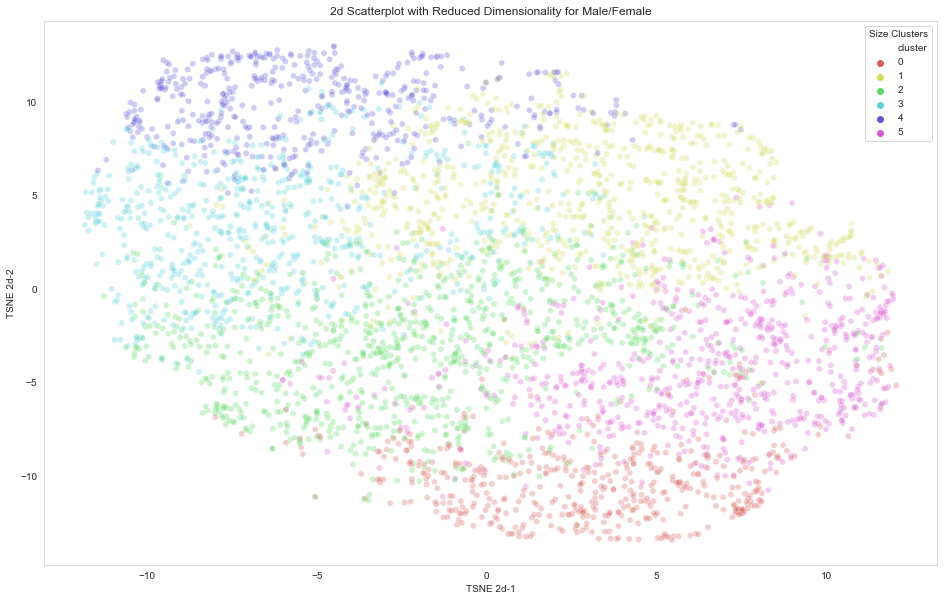

In [118]:
plt.figure(figsize=(16,10))
sn.set_style("whitegrid", {'axes.grid' : False})
ax = sn.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="cluster",
    palette=sn.color_palette("hls", 6),
    data=df_scaled,
    legend="full",
    alpha=0.3)

ax.set(xlabel='TSNE 2d-1', ylabel='TSNE 2d-2')


leg = ax.axes.get_legend()
new_title = 'Size Clusters'
leg.set_title(new_title)

plt.legend(title='Size Clusters', loc='upper right')
plt.title("2d Scatterplot with Reduced Dimensionality for Male/Female")
plt.savefig("Scatterplot")

Having the cluster features we will apply a ML model to derive the feature importances and understand which metric is the most important one.

In [119]:
df_scaled.drop(['tsne-2d-one','tsne-2d-two'],axis=1,inplace=True)
x_train, x_test, y_train, y_test = train_test_split(
    df_scaled.drop(['cluster'],axis=1), df_scaled['cluster'], test_size=.25, random_state=42)

We will create a basic RandomForestClassifier, and then will apply RandomizedSearch for the best results

In [120]:
model_rf = RandomForestClassifier(random_state=42, class_weight='balanced')
model_rf.fit(x_train,y_train)

print("Accuracy on train set",round(model_rf.score(x_train,y_train)*100,3),"%")
print("Accuracy on test set",round(model_rf.score(x_test,y_test)*100,3),"%")

rf_pred = model_rf.predict(x_test)
print("Mean Squared Error",round(mean_squared_error(y_test,rf_pred),3))
print("-"*100)
print(confusion_matrix(y_test, rf_pred))
print("-"*100)
print(classification_report(y_test, rf_pred))

Accuracy on train set 99.281 %
Accuracy on test set 83.35 %
Mean Squared Error 1.129
----------------------------------------------------------------------------------------------------
[[112   0   7   0   0   5]
 [  0 188  10   7   2  11]
 [  8   7 193   8   0  10]
 [  0  14  20 125   7   0]
 [  0  13   0  13 109   0]
 [  6  10  12   0   0 124]]
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.90      0.90       124
           1       0.81      0.86      0.84       218
           2       0.80      0.85      0.82       226
           3       0.82      0.75      0.78       166
           4       0.92      0.81      0.86       135
           5       0.83      0.82      0.82       152

    accuracy                           0.83      1021
   macro avg       0.84      0.83      0.84      1021
weighted avg       0.84      0.83      0.83      1021



In [121]:
params_rf = {'max_depth': [i for i in range(2,17)],
          'max_features': [i for i in range(2,10,2)],
          'min_samples_leaf': [3,7,8,10],
          'min_samples_split': [z for z in range(4,21,2)],
          'n_estimators':[int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
          'bootstrap': [True, False]}

random_search_rf = RandomizedSearchCV(model_rf, param_distributions=params_rf, n_jobs=-1)
random_search_rf.fit(x_train,y_train)

RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight='balanced',
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators=10,
                                                    n_jo

In [122]:
random_search_rf.best_params_

{'n_estimators': 1200,
 'min_samples_split': 6,
 'min_samples_leaf': 8,
 'max_features': 2,
 'max_depth': 10,
 'bootstrap': True}

In [123]:
tuned_rf = RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators= 400, 
                                  min_samples_split= 18, min_samples_leaf= 10,
                                  max_features= 2, max_depth=8, bootstrap=False)
tuned_rf.fit(x_train,y_train)

RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       criterion='gini', max_depth=8, max_features=2,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=10,
                       min_samples_split=18, min_weight_fraction_leaf=0.0,
                       n_estimators=400, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

In [124]:
print("Accuracy on train set",round(tuned_rf.score(x_train,y_train)*100,3),"%")
print("Accuracy on test set",round(tuned_rf.score(x_test,y_test)*100,3),"%")

tuned_rf_pred = tuned_rf.predict(x_test)
print("Mean Squared Error",round(mean_squared_error(y_test,tuned_rf_pred),3))

print("-"*100)
print(confusion_matrix(y_test, tuned_rf_pred))
print("-"*100)
print(classification_report(y_test, tuned_rf_pred))

Accuracy on train set 95.949 %
Accuracy on test set 88.051 %
Mean Squared Error 0.712
----------------------------------------------------------------------------------------------------
[[120   0   3   0   0   1]
 [  0 187   8   8   5  10]
 [  8   3 193  14   0   8]
 [  0   8  10 139   9   0]
 [  0   6   0   6 123   0]
 [  4   2   9   0   0 137]]
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       124
           1       0.91      0.86      0.88       218
           2       0.87      0.85      0.86       226
           3       0.83      0.84      0.83       166
           4       0.90      0.91      0.90       135
           5       0.88      0.90      0.89       152

    accuracy                           0.88      1021
   macro avg       0.88      0.89      0.88      1021
weighted avg       0.88      0.88      0.88      1021



In [125]:
importances = tuned_rf.feature_importances_
features = pd.DataFrame(data = importances, columns = ["importance"], 
                        index = df_scaled.drop(['cluster'],axis=1).columns)
features.sort_values('importance',ascending=False)

,importance
chestcircumference,0.125716
cervicaleheight,0.115322
forearmcenterofgriplength,0.089021
acromionradialelength,0.081531
hipbreadth,0.075201
abdominalextensiondepthsitting,0.066943
neckcircumferencebase,0.062164
chestbreadth,0.060562
biacromialbreadth,0.055971
bicristalbreadth,0.051323


Text(0, 0.5, 'Features')

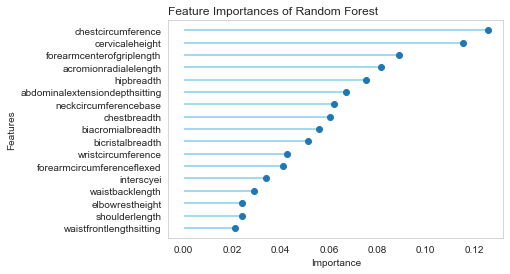

In [126]:
 # Reorder it following the values:
ordered_df = features.sort_values('importance',ascending=True)
my_range=range(1,len(ordered_df.index)+1)
 
# The vertival plot is made using the hline function
plt.hlines(y=my_range, xmin=0, xmax=ordered_df['importance'], color='skyblue')
plt.plot(ordered_df['importance'], my_range, "o")
 
# Add titles and axis names
plt.yticks(my_range, ordered_df.index)
plt.title("Feature Importances of Random Forest", loc='left')
plt.xlabel('Importance')
plt.ylabel('Features')

Having the chest circumference as the most important factor we will continue with that variable. We can surely divide the chestcircumference range into the cluster distances for the optimal division of sizes. So, the new metric for sizes will be the chest circumference. 